In [2]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# 仅处理21位序列号中数字部分
train_data = []
train_label = []

In [4]:
# 根据annotion.txt读取图像
def Batch_Read(filename):
    filename = "test_data/" + filename
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    return img

In [5]:
# 1.车票票面检测
def Ticket_Detect(img):
    # 1.1.预处理
    # 中值滤波：去除黑色背景中的盐噪声，只用来做边缘提取的效果很好，size取3,5,7均可
    img_blur = cv2.medianBlur(img, 7)
    # OTSU阈值 二值化
    _, img_blur_Otsu = cv2.threshold(img_blur, 0, 255, cv2.THRESH_OTSU)
    #利用Canny算子检测图像的边缘
    edges = cv2.Canny(img_blur_Otsu, 50, 150, apertureSize = 3)
    
    #1.2.寻找矩形位置并分割
    # 获取轮廓
    (contours, _) = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    for i, c in enumerate(contours):  #遍历轮廓
        rect = cv2.minAreaRect(c)  # 生成最小外接矩形，得到最小外接矩形的（中心(x,y), (宽,高), 旋转角度）
        box = np.int0(cv2.boxPoints(rect))  # 获取最小外接矩形的 4个顶点坐标
    
        # 根据面积过滤不需要的矩形（估计车票为700x1000）
        area = cv2.contourArea(box)
        if area < 400000: continue
        if area > 1000000: continue    
    
        rect_w, rect_h = int(rect[1][0]) + 1, int(rect[1][1]) + 1  # 最小外接矩形的宽和高        
        angle = rect[2]  #获取矩形相对于水平面的角度
        #以矩形的右下角为旋转中心
        if (rect_w > rect_h):
            x0, y0 = int(box[0][0]), int(box[0][1])
            M = cv2.getRotationMatrix2D((x0, y0), angle, 1)
        else:        
            t = rect_h
            rect_h = rect_w
            rect_w = t
            x0, y0 = int(box[3][0]), int(box[3][1])
            M = cv2.getRotationMatrix2D((x0, y0), angle - 90, 1)
    
        img_ro = cv2.warpAffine(img, M, (img.shape[1] * 2, img.shape[0]))
        img_seg = img_ro[(y0 - rect_h) : y0, x0 : (x0 + rect_w)]
        
        
        #1.3.倒立校正
        #计算最上方和最下方的平均灰度值
        avg1 = np.average(img_seg[0:75, 0:rect_w])
        avg2 = np.average(img_seg[rect_h-75:rect_h,0:rect_w])
        img_fix = np.copy(img_seg)
        if (avg1 < avg2):
            M = cv2.getRotationMatrix2D((rect_w / 2, rect_h / 2), 180, 1)
            img_fix = cv2.warpAffine(img_seg, M, (rect_w, rect_h))
        
        return img_fix, rect_w, rect_h



In [6]:
#2.序列号定位与分割
#2.1处理21位序列号
def Num_21(img, rect_w, rect_h):  
    box_21 = np.array([int(rect_h*0.84), int(rect_w * 0.03), rect_h, int(rect_w * 0.5)]).reshape(2, 2)
    img_21 = img[box_21[0,0]:box_21[1,0], box_21[0,1]:box_21[1,1]] 
    
    
    # 多次均值模糊+高斯模糊（增加了序列号的连通度，理想状态下能够直接连通成一个区域）
    # 多次开运算去除序列号之间的“桥”，连通为一个区域
    img_21 = cv2.blur(img_21, (9, 9))
    img_21 = cv2.blur(img_21, (9, 9))
    #二值化
    _,img_21 = cv2.threshold(img_21, 0, 255, cv2.THRESH_OTSU)
    ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))    
    rectangle = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    img_21_open = cv2.morphologyEx(img_21, cv2.MORPH_OPEN, ellipse)
    img_21_open = cv2.morphologyEx(img_21_open, cv2.MORPH_OPEN, rectangle)
    
    # 获取轮廓
    (contours, _) = cv2.findContours(~img_21_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    c_max = contours[0]
    area_max = cv2.contourArea(c_max)
    for i, c in enumerate(contours):  #遍历轮廓
        # 找到面积最大的连通区域
        area = cv2.contourArea(c)
        if area_max < area:
            area_max = area
            c_max = c
    rect_21_max = cv2.minAreaRect(c_max)  # 生成最小外接矩形，得到最小外接矩形的（中心(x,y), (宽,高), 旋转角度）
    box_21_max = np.int0(cv2.boxPoints(rect_21_max))  # 获取最小外接矩形的 4个顶点坐标
    box_21_max[:,0] += box_21[0,1]
    box_21_max[:,1] += box_21[0,0]    
    
    
    img_con = cv2.cvtColor(np.copy(img), cv2.COLOR_GRAY2RGB)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    x_min = np.min(box_21_max[:,0]) 
    x_max = np.max(box_21_max[:,0]) 
    y_min = np.min(box_21_max[:,1])
    y_max = np.max(box_21_max[:,1])
    #字母的宽度略大于数字的宽度，估计数字的宽度
    step_x = (x_max - x_min) / 21 * 0.97    


    x_1 = x_min
    for i in range(1, 15):
        x_2 = x_min + round(step_x * i)
        box = np.array([[x_1, y_max],[x_1, y_min],[x_2, y_min],[x_2,y_max]])
        cv2.drawContours(img_con, [box], 0, (0, 0, 255), 2)
        data = np.array(img[y_min:y_max, x_1:x_2]) / 255.0
        data = cv2.resize(data,(20, 20), interpolation = cv2.INTER_NEAREST)
        train_data.append(data)
        x_1 = x_2

    x_4 = x_max
    for i in range(1, 7):
        x_3 = x_max - round(step_x * i)
        box = np.array([[x_3, y_max],[x_3, y_min],[x_4, y_min],[x_4,y_max]])
        cv2.drawContours(img_con, [box], 0, (0, 0, 255), 2)
        data = np.array(img[y_min:y_max, x_3:x_4]) / 255.0
        data = cv2.resize(data,(20, 20), interpolation = cv2.INTER_NEAREST)
        train_data.append(data)
        x_4 = x_3

    box = np.array([[x_2, y_max],[x_2, y_min],[x_3, y_min],[x_3,y_max]])
    cv2.drawContours(img_con, [box], 0, (0, 0, 255), 2)
    
    return img_con

In [7]:
with open('annotation.txt', 'r') as file_r:
    for row in file_r:
        filename, num_21, num_7 = row.split()
        for i in range(0, 14):
            train_label.append(num_21[i])
        for i in range(20, 14, -1):
            train_label.append(num_21[i])
        img = Batch_Read(filename)
        img_fix, rect_w, rect_h = Ticket_Detect(img)
        img_con_21 = Num_21(img_fix, rect_w, rect_h)

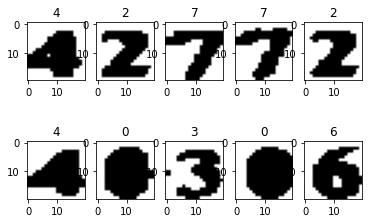

In [15]:
for i in range(11, 21):
    plt.subplot(2, 5, i - 10)
    plt.imshow(train_data[i], cmap = 'gray')
    plt.title(train_label[i])
plt.show()

In [19]:
from skimage.feature import hog
from sklearn import svm

X = []
imgs = []
for data in train_data:
    fd, img_hog = hog(data, pixels_per_cell = (4, 4),
              cells_per_block = (2, 2), multichannel = False, feature_vector = True, visualize = True)
    X.append(fd)
    imgs.append(img_hog)
X = np.array(X)
Y = np.reshape(train_label,(-1,))
clf = svm.SVC(C = 1.0)
clf.fit(X, Y)


SVC()

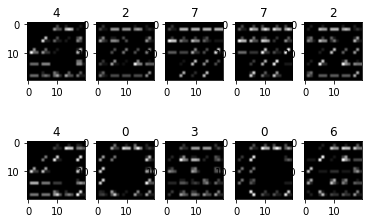

In [21]:
from skimage import io
for i in range(11, 21):
    plt.subplot(2, 5, i - 10)
    plt.imshow(imgs[i], cmap = 'gray')
    plt.title(Y[i])
plt.show()

In [10]:

# 保存模型参数
import joblib
joblib.dump(clf, 'digits_21_svm.pkl');